In [7]:
%matplotlib inline

In [8]:
# Setting up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import create_engine, inspect
import psycopg2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn as skl
import ast

from config import user, password, hostname

# Preprocessing
### In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors. 

## Connecting to database

In [9]:
# Create engine
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{hostname}/twitter_vs_stocks')

# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['stock', 'tweets_text', 'twitter_vs_stocks']

In [27]:
# Create dataframe from SQL table
twitter_vs_stocks = pd.read_sql_table(
    'twitter_vs_stocks',
    con=engine)
twitter_vs_stocks.set_index(['date'], inplace=False)
twitter_vs_stocks.rename({'volume': 'volume_traded'}, axis=1, inplace=True)
twitter_vs_stocks.head()

,date,tokenized_text,like_count,reply_count,retweet_count,volume_traded,change
0,2011-12-01,"['made', 'volume', 'model', 'go', 'need', 'wor...",267,63,24,5151000.0,-0.028
1,2011-12-21,"['yum', 'even', 'better', 'deep', 'fried', 'bu...",1330,87,597,8527500.0,-0.066
2,2011-12-22,"['model', 'options', 'performance', 'red', 'bl...",1349,132,206,5047000.0,0.040
3,2011-12-27,"['ever', 'wanted', 'know', 'real', 'truth', 'm...",39,13,34,3887500.0,0.134
4,2011-12-28,"['theonion', 'true']",12,7,1,2876000.0,-0.012


### Defining the most common words in tweets

In [28]:
# define function for counting words
def count_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [29]:
# count words in tweets
words_in_tweets = count_words(twitter_vs_stocks.tokenized_text)
print(f'Elon Musked used {len(words_in_tweets)} word in his tweets.')
print(f'The most popular words:')
words_in_tweets[:30]

Elon Musked used 6428 word in his tweets.
The most popular words:


[('tesla', 450),
 ('model', 197),
 ('spacex', 171),
 ('car', 119),
 ('falcon', 118),
 ('launch', 113),
 ('good', 112),
 ('rocket', 108),
 ('like', 102),
 ('cars', 81),
 ('new', 81),
 ('next', 81),
 ('first', 79),
 ('people', 79),
 ('time', 78),
 ('dragon', 76),
 ('great', 71),
 ('would', 66),
 ('thanks', 66),
 ('space', 65),
 ('landing', 63),
 ('much', 62),
 ('mars', 62),
 ('solar', 61),
 ('test', 61),
 ('soon', 59),
 ('year', 58),
 ('flight', 58),
 ('one', 57),
 ('high', 57)]

In [30]:
# analyse only words that appear 3 or more times
words_to_analyse = [word for word, freq in words_in_tweets if freq >= 3]
print(f'There are {len([word for word, freq in words_in_tweets if freq < 3])} words used once or twice.')
print(f'There are {len(words_to_analyse)} words left for analysis.')
words_to_analyse[:10]

There are 4603 words used once or twice.
There are 1825 words left for analysis.


['tesla',
 'model',
 'spacex',
 'car',
 'falcon',
 'launch',
 'good',
 'rocket',
 'like',
 'cars']

### Count words in tweets

In [31]:
# count words in the tokenized text (tweets)
for column in words_to_analyse:
    count_list = []
    for row in np.arange(0,len(twitter_vs_stocks.tokenized_text)):
         count_list.append(twitter_vs_stocks.tokenized_text[row].count(column))
    twitter_vs_stocks[column] = count_list

In [32]:
twitter_vs_stocks.head()

,date,tokenized_text,like_count,reply_count,retweet_count,volume_traded,change,tesla,model,spacex,...,cell,interests,jwangark,suppliers,nets,crypto,cov2,cyberpunk,sn10,nbcsnl
0,0,"['made', 'volume', 'model', 'go', 'need', 'wor...",267,63,24,5151000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"['yum', 'even', 'better', 'deep', 'fried', 'bu...",1330,87,597,8527500.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,"['model', 'options', 'performance', 'red', 'bl...",1349,132,206,5047000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,"['ever', 'wanted', 'know', 'real', 'truth', 'm...",39,13,34,3887500.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,"['theonion', 'true']",12,7,1,2876000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling and Features Extraction

In [33]:
X = twitter_vs_stocks.drop(columns=['tokenized_text', 'change', 'volume_traded'])
y_change = twitter_vs_stocks.change
y_volume = twitter_vs_stocks.volume

In [34]:
X.head()

,date,like_count,reply_count,retweet_count,tesla,model,spacex,car,falcon,launch,...,cell,interests,jwangark,suppliers,nets,crypto,cov2,cyberpunk,sn10,nbcsnl
0,0,267,63,24,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1330,87,597,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1349,132,206,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,39,13,34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,12,7,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tagret is Change

In [35]:
# Split dataset to training and testing
X_train, X_test, y_change_train, y_change_test = train_test_split(X, y_change, random_state=12)

In [36]:
# Create scaler instance
scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
len(X_test_scaled)

300

Text(0, 0.5, 'cumulative explained variance')

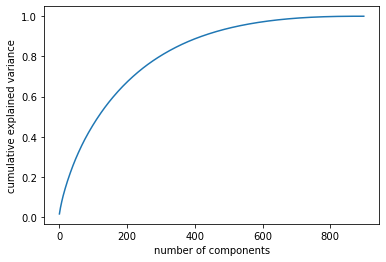

In [38]:
# choose number of components for PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#### we need at least 600 components to describe 90% of the variance

In [39]:
# Reduce the number of components in X using PCA
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#### Tagret is Volume Traded

In [40]:
# Split dataset to training and testing
X_train, X_test, y_volume_train, y_volume_test = train_test_split(X, y_volume, random_state=10)

In [41]:
scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

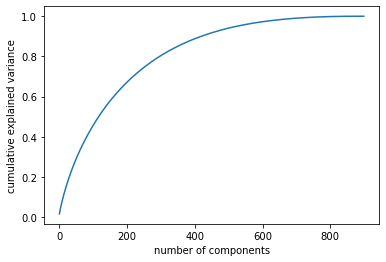

In [42]:
# choose number of components for PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [43]:
# Reduce the number of components in X using PCA
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# ML Model